In [44]:


import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from IPython.core.display import clear_output
from shaolin import KungFu,Dashboard
class DensityPlot(Dashboard):
    def __init__(self,data):
        d_kwargs= {'num_xbins':(1,40,2,10),
                 'num_ybins':(1,40,2,10),
                 'grid': True,
                 'link_bins':True,
                 'plot_density':True,
                 'reg_order':(1,10,1,1),
                 'ci':"(1,100,1,95)$N=ci&d=Confidence intervals",
                 'robust':[False],
                 'scatter':True,
                 'regression':True,
                 'marginals':(['None','Histogram','KDE','Both'],'Both'),
                 'bw':(0.001,10,0.05,0.5),
                 'Title':'#Combining plots$N=title&D=',
                 'dataset':['ALL','I','II','III','IV'],
                 'save':False,
                 #'@kernel':['gau','cos','biw','epa','tri','triw']
                }
        #general
        title = '#Exploratory plots$N=title&D='
        marginals = "@['Both','None','Histogram','KDE']$d=Marginals"
        
        dset = "@['ALL','I','II','III','IV']$D=Dataset"
        x_cols = '@dd$D=X column&o='+str(data.columns.values.tolist())
        y_cols = '@dd$D=Y column&o='+str(data.columns.values.tolist())+'&v='+data.columns[1]
        save = "@[False]$D=Save plot&n=save"
        data_layout = ['c$N=data_layout',[title,dset,['r$N=sub_row',[x_cols,y_cols]],marginals,save]]
        #histograms
        h_title = '#Historam options$N=h_title&D='
        num_xbins = '@(1,40,2,10)$D=Num xbins&n=num_xbins'
        num_ybins = '@(1,40,2,10)$D=Num ybins&n=num_ybins'
        lbins = '@True$D=link_bins'
        hist_layout = ['c$N=hist_layout',[h_title,num_xbins,num_ybins,lbins]]
        
        #scatter
        s_title = '#Scatterplot options$N=s_title&D='
        scat = '@[True]$D=Plot Scatter&n=scatter' 
        grid = '@True$D=Grid'
        scatter_layout = ['c$N=scatter_layout',[s_title,scat,grid]]
        #regression
        r_title = '#Regression options$N=r_title&D='
        reg = '@[True]$D=Plot Regression&n=regression'
        robust = '@True$D=Robust'
        reg_order = "@(1,10,1,1)$D=Reg order"
        ci = "@(1,100,1,95)$N=ci&d=Confidence intervals"
        reg_layout = ['c$N=reg_layout',[r_title,reg,reg_order,ci,robust]]
        #kde
        k_title = '#KDE plot options$N=k_title&D='
        kde = '@[True]$D=Plot KDE&n=plot_density'
        bw =  "@(0.001,10,0.05,0.5)$D=Bandwidth&n=bw"
        kde_layout = ['@c$N=kde_layout',[k_title,kde,bw]]
        dash = ['ac$N=dae_plot&t=General,Histogram,Scatter,KDE,Regression',[data_layout,
                                                                        hist_layout,
                                                                        scatter_layout,
                                                                        kde_layout,
                                                                        reg_layout,
                                                                       ]
               ]
        self.data = data
        Dashboard.__init__(self,dash=dash,mode='interactive')
        
        self.num_xbins.widget.continuous_update=False
        self.num_ybins.widget.continuous_update=False
        self.density_plot()
        
        
        self.plot_density.value = False
        self.regression.value = False
        self.marginals.value = 'None'
        self.scatter.value = False
        self.grid.value = False
        
        
        self.link_bins.observe(self.link_sliders)
        self.observe(self.density_plot)
        self.link_sliders()
        """self.marginal_x.value = 'None'
        self.scatter.value = False
        self.grid.value = False
        self.plot_density.value = False"""
        #self.density_plot()
        self._i_plot = 0
        #time.sleep(1)
        #self.grid.value = True
        
        
    
    def link_sliders(self,_=None):
        if self.link_bins():
            self.num_ybins.visible = False
            self.link('num_xbins','num_ybins')
        else:
            self.unlink('num_xbins','num_ybins')
            self.num_ybins.visible = True
            
    def density_plot(self,_=None):
        clear_output()
        #if len(self.columns())>1:
        #    subdf = self.data[list(self.columns())]
        if self.kwargs['dataset']=='ALL':
            self.x_column.value = 'x'
            self.y_column.value = 'y'
            subdf = self.data.copy()
        else:
            subdf = self.data[self.data['dataset']==self.dataset()].copy()
        x,y = subdf[self.x_column()],subdf[self.y_column()]
        x_regions = 10
        y_regions = 10
        x_bins = np.linspace(x.min(),x.max(),num=self.kwargs['num_xbins'])
        y_bins = np.linspace(y.min(),y.max(),num=self.kwargs['num_ybins'])
        
        g = sns.JointGrid(x=self.x_column(), y=self.y_column(), data=subdf)
        
        g.fig.set_figwidth(14)
        g.fig.set_figheight(9)
        if self.kwargs['plot_density']:
            g = g.plot_joint(sns.kdeplot, shade=True,alpha=0.5,legend=True,bw=self.kwargs['bw'],
                             gridsize=int((len(x_bins)+len(y_bins))/2),
                             clip=((x.min()*0.95,x.max()*1.05),(y.min()*0.95,y.max()*1.05)))
        
        if self.kwargs['scatter']:# and not self.kwargs['regression']:
            g = g.plot_joint(plt.scatter,s=80,alpha=0.8)
            
        
        if self.kwargs['marginals'] in ['Histogram','Both']:
            _ = g.ax_marg_x.hist(x, alpha=.6,
                                  bins=x_bins,normed=True)
            _ = g.ax_marg_y.hist(y, alpha=.6,
                                   orientation="horizontal",
                                   bins=y_bins,normed=True)
        if self.kwargs['marginals'] in ['KDE','Both']:
            clip = ((x.values.min()*0.95,x.values.max()*1.05),(y.values.min()*0.95,y.values.max()*1.05))
            g = g.plot_marginals(sns.kdeplot, shade=True,alpha=0.5,
                             gridsize=int((len(x_bins)+len(y_bins))/2))
                             #clip=clip)
        if self.kwargs['regression']:
            g = g.plot_joint(sns.regplot,
                             robust=self.kwargs['robust'],
                             ci=self.kwargs['ci'],
                             order=self.kwargs['reg_order'],
                             truncate=True,
                             scatter_kws={"s": 0})
        if self.kwargs['grid']:
            plt.grid(linewidth=2) 
            plt.xticks(x_bins)
            plt.yticks(y_bins)
            
        plt.xlim(x.values.min()*0.95,x.values.max()*1.05)
        plt.ylim(y.values.min()*0.95,y.values.max()*1.05)
         
        
        #_ = plt.show()
        if self.kwargs['save']:
            _ =plt.savefig("density_plot_{}.png".format(self._i_plot), dpi=100)
            self._i_plot += 1
        #clear_output(True)

In [45]:
from IPython.core.display import display
%matplotlib inline
sns.set(style="ticks")

In [46]:
df = sns.load_dataset("anscombe")

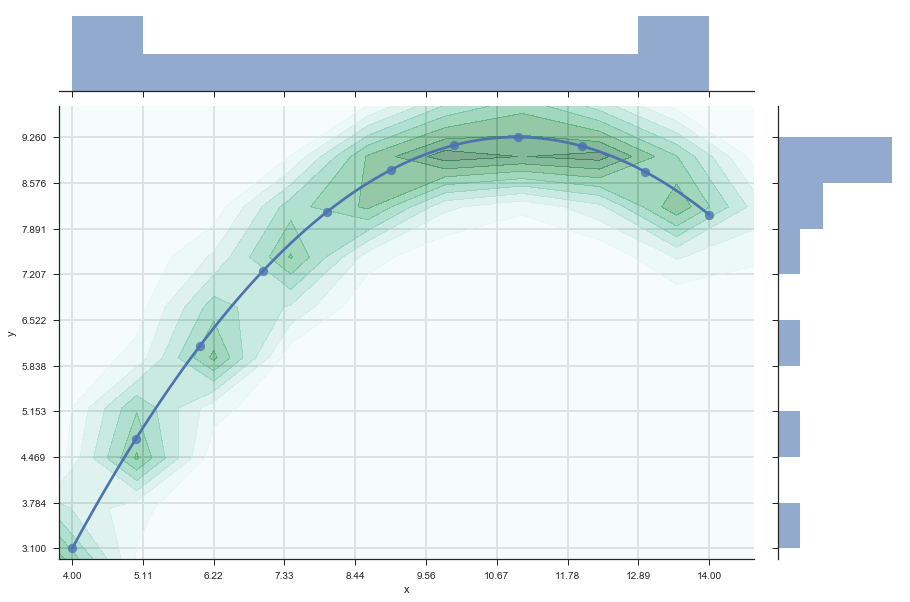

In [47]:

DensityPlot(df)[0]

In [48]:
1080*16/9*1080

2073600.0

In [ ]:
32*32